<a href="https://colab.research.google.com/github/pratap977/CS6910/blob/main/Assignment-3/Without_Attention(1-4)/RNN_WithoutAttention_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dakshina Dataset from google


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
from tensorflow.keras.utils import plot_model
from copy import copy
from math import log
import math


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar

--2022-05-08 14:35:39--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G   225MB/s    in 9.3s    

2022-05-08 14:35:49 (205 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



In [6]:
!tar -xvf '/content/dakshina_dataset_v1.0.tar'

dakshina_dataset_v1.0/bn/
dakshina_dataset_v1.0/bn/lexicons/
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv
dakshina_dataset_v1.0/bn/native_script_wikipedia/
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.valid.text.shuf.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.info.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.info.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.text.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.text.shuf.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.nonblock.sections.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.omit_pages.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.text.sorted.tsv.gz
dakshina_dataset_v1.0/bn/na

In [11]:
train_filename = 'dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv'
validation_filename = 'dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv'
test_filename = 'dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv'

In [7]:
def processData(filename,input_chars=set(),target_chars=set()):
  input=[]
  target=[]
  with open(filename, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
  for line in lines[:len(lines)-1]:
      t_text,i_text, attestation = line.split("\t")
       # We use "\t" as the "start sequence" character and "\n" as "end sequence" character for the target text.
      input.append(i_text)
      target.append("\t"+t_text+"\n")
      for char in i_text:
        if char not in input_chars:
            input_chars.add(char)
      for char in t_text:
        if char not in target_chars:
            target_chars.add(char)
  target_chars.add("\t")
  target_chars.add("\n")
  input_chars = sorted(list(input_chars))
  target_chars = sorted(list(target_chars))
  num_encoder_tokens = len(input_chars)
  num_decoder_tokens = len(target_chars)
  max_encoder_seq_length = max([len(txt) for txt in input])
  max_decoder_seq_length = max([len(txt) for txt in target])
  return input,target,input_chars,target_chars,num_encoder_tokens,num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length     

In [12]:
# Vectorize the data.
input,target,input_chars,target_chars,num_encoder_tokens,num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length=processData(train_filename)
print("Number of samples:", len(input))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 44204
Number of unique input tokens: 26
Number of unique output tokens: 65
Max sequence length for inputs: 20
Max sequence length for outputs: 21


In [13]:
# Vectorize the data.
# Vectorize the data.
validation_input,validation_target,input_chars,target_chars,num_encoder_tokens,num_decoder_tokens, validation_max_encoder_seq_length, validation_max_decoder_seq_length=processData(validation_filename,set(input_chars),set(target_chars))

print("Number of validation samples:", len(validation_input))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("validation Max sequence length for inputs:", validation_max_encoder_seq_length)
print("validation Max sequence length for outputs:", validation_max_decoder_seq_length)

Number of validation samples: 4358
Number of unique input tokens: 26
Number of unique output tokens: 65
validation Max sequence length for inputs: 18
validation Max sequence length for outputs: 16


In [14]:
# Vectorize the data.
test_input,test_target,test_input_chars,test_target_chars,test_num_encoder_tokens,test_num_decoder_tokens, test_max_encoder_seq_length, test_max_decoder_seq_length=processData(test_filename)
print("Number of validation samples:", len(test_input))
print("Test Max sequence length for inputs:", test_max_encoder_seq_length)
print("Test Max sequence length for outputs:", test_max_decoder_seq_length)

Number of validation samples: 4502
Test Max sequence length for inputs: 16
Test Max sequence length for outputs: 17


In [15]:
input_token = dict([(char, i) for i, char in enumerate(input_chars)])
target_token = dict([(char, i) for i, char in enumerate(target_chars)])

reverse_input_token = dict((i, char) for char, i in input_token.items())
reverse_target_token = dict((i, char) for char, i in target_token.items())


encoder_input_data = np.zeros(
    (len(input), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
validation_encoder_input_data=np.zeros(
    (len(validation_input), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
test_encoder_input_data=np.zeros(
    (len(test_input), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
validation_decoder_input_data =np.zeros(
    (len(validation_input), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
validation_decoder_target_data = np.zeros(
    (len(validation_input), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input, target)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token[char]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token[char]] = 1.0
# for validation data
for i, (validation_input_text, validation_target_text) in enumerate(zip(validation_input, validation_target)):
    for t, char in enumerate(validation_input_text):
        validation_encoder_input_data[i, t, input_token[char]] = 1.0
    for t, char in enumerate(validation_target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        validation_decoder_input_data[i, t, target_token[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            validation_decoder_target_data[i, t - 1, target_token[char]] = 1.0

# for test data
for i, (test_input_text, test_target_text) in enumerate(zip(test_input, test_target)):
    for t, char in enumerate(test_input_text):
        test_encoder_input_data[i, t, input_token[char]] = 1.0

In [16]:
def beam_search_decoder(data, k):
    decodedWords = [[list(), 0.0]]
    # walk over each step in sequence
    for word in data:
      candidates = list()
      # expand each current candidate
      for sequence in decodedWords:
        seq, score = sequence
        for j in range(len(word)):
          candidate = [seq + [j], score - log(word[j])]
          candidates.append(candidate)
      # order all candidates by score
      ordered = sorted(candidates, key=lambda a:a[1])
      # select k best
      decodedWords = ordered[:k]
    return decodedWords
  
def translate(seq):
  sentence = [] 
  for x in seq:
    char = reverse_target_token[x]
    sentence.append(char)
  return "".join(sentence)





In [17]:
class WordAccuracyCallback(keras.callbacks.Callback):
  def __init__(self,beam_size):
    self.beam_size=beam_size
  def on_epoch_end(self, epoch, logs=None):
    pred=self.model.predict([validation_encoder_input_data,validation_decoder_input_data])
    count=0
    for i in range(pred.shape[0]):
      pSequences=beam_search_decoder(pred[i],self.beam_size)
      for j in range(self.beam_size):
        if "\t"+translate(pSequences[j][0][:len(validation_target[i])-1])==validation_target[i]:
          count=count+1
          break
    factor = 10.0 ** 4
    logs["WordAccuracy"]=math.trunc((count/pred.shape[0])*factor)/factor
    print("- wordAccuracy:",logs["WordAccuracy"])

In [18]:
class seq2seq_Model:

  def __init__(self,no_of_encoder_layers,no_of_decoder_layers,latent_dimension,dropout,recurrent_dropout,cell_type,beam_size):
    
    self.model = None
    self.encoder_inputs= None
    self.encoder_states = None
    self.decoder_inputs = None
    self.output_layers = []
    self.decoder_dense = None
    self.no_of_encoder_layers = no_of_encoder_layers
    self.no_of_decoder_layers = no_of_decoder_layers
    self.latent_dimension = latent_dimension
    self.dropout = dropout
    self.recurrent_dropout=recurrent_dropout
    self.cell_type=cell_type
    self.beam_size = beam_size
    self.encoder_model=None
    self.decoder_model=None

#this function builds and fits the model 
  def BUILD_FIT_MODEL(self,encoder_input_data,decoder_input_data ,decoder_target_data,epochs ,batch_size,validation_encoder_input_data,validation_decoder_input_data,validation_decoder_target_data,num_encoder_tokens,num_decoder_tokens):
    self.encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
    outputs = self.encoder_inputs
    self.encoder_states = []

    #initially we accumulter the outputs from the encoders and the states obtained
    for j in range(self.no_of_encoder_layers)[::-1]:
      if self.cell_type == "LSTM":
        outputs, state_h , state_c = keras.layers.LSTM(self.latent_dimension*(2**(self.no_of_encoder_layers-j-1)), return_state=True, return_sequences=bool(j),dropout=self.dropout,recurrent_dropout=self.recurrent_dropout)(outputs)
        self.encoder_states += [ state_h , state_c]
      elif self.cell_type == "GRU" :
        outputs, state_h = keras.layers.GRU(self.latent_dimension*(2**(self.no_of_encoder_layers-j-1)), return_state=True, return_sequences=bool(j),dropout=self.dropout,recurrent_dropout=self.recurrent_dropout)(outputs)
        self.encoder_states += [state_h]
      elif self.cell_type == "RNN" :
        outputs, state_h = keras.layers.SimpleRNN(self.latent_dimension*(2**(self.no_of_encoder_layers-j-1)), return_state=True, return_sequences=bool(j),dropout=self.dropout,recurrent_dropout=self.recurrent_dropout)(outputs)
        self.encoder_states += [state_h]
    
    self.decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))
    outputs = self.decoder_inputs
    #here we save the layers of decoder for fututere use but at the same time we go on to get the final output  
    for j in range(self.no_of_decoder_layers):

      # at each layer we are giving the dimensions as latent_dimension*2**(layer_number-1)
        if self.cell_type == "LSTM":
          self.output_layers.append(
              keras.layers.LSTM(self.latent_dimension*(2**(j)), return_sequences=True, return_state=True,dropout=self.dropout,recurrent_dropout=self.recurrent_dropout)
          )
          outputs, dh, dc = self.output_layers[-1](outputs, initial_state=self.encoder_states[2*j:2*(j+1)])
        elif self.cell_type == "GRU" : 
          self.output_layers.append(
              keras.layers.GRU(self.latent_dimension*(2**(j)), return_sequences=True, return_state=True,dropout=self.dropout,recurrent_dropout=self.recurrent_dropout)
          )
          outputs, dh = self.output_layers[-1](outputs, initial_state=self.encoder_states[j:j+1])
        elif self.cell_type == "RNN" : 
          self.output_layers.append(
              keras.layers.SimpleRNN(self.latent_dimension*(2**(j)), return_sequences=True, return_state=True,dropout=self.dropout,recurrent_dropout=self.recurrent_dropout)
          )
          outputs, dh = self.output_layers[-1](outputs, initial_state=self.encoder_states[j:j+1])

 
    self.decoder_dense = keras.layers.Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = self.decoder_dense(outputs)
    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    self.model = keras.Model([self.encoder_inputs, self.decoder_inputs], decoder_outputs)
    self.model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy']) 
    self.model.fit(
        [encoder_input_data, decoder_input_data],
        decoder_target_data,
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        callbacks = [WordAccuracyCallback(self.beam_size)],verbose=1)
        # callbacks = [WordAccuracyCallback(self.beam_size),WandbCallback(monitor='WordAccuracy',
        #                                             save_model = True)],verbose=1)
    return 

  def load_model(self):
    encoder_model = keras.Model(self.encoder_inputs, self.encoder_states)
    d_output = self.decoder_inputs
    decoder_s_inputs = []
    decoder_states = []
    for j in range(self.no_of_decoder_layers):
        if self.cell_type =="LSTM":
          current_inputs = [keras.Input(shape=(self.latent_dimension*(2**(j)),)) for _ in range(2)]
        else :
          current_inputs = [keras.Input(shape=(self.latent_dimension*(2**(j)),))]

        out = self.output_layers[j](d_output, initial_state=current_inputs)

        d_output, cur_states = out[0], out[1:]

        decoder_states += cur_states
        decoder_s_inputs += current_inputs

    outputs = self.decoder_dense(d_output)
    decoder_model = keras.Model(
        [self.decoder_inputs] + decoder_s_inputs,
        [outputs] + decoder_states)
    self.encoder_model=encoder_model
    self.decoder_model=decoder_model
  def decode_sequence_using_inference(self,input_seq):
    # Encode the input as state vectors.
    states_values = self.encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token['\t']] = 1.


    decoded_sentence = []  
    while True:
        to_split = self.decoder_model.predict([target_seq] + states_values)

        output_token, states_values = to_split[0], to_split[1:]

        # Sample a token
        token_index = np.argmax(output_token[0, 0])
        char = reverse_target_token[token_index]
        decoded_sentence.append(char)

        # Exit condition: either hit max length
        # or find stop character.
        if char == '\n' or len(decoded_sentence) > max_decoder_seq_length:
            break

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, token_index] = 1.

    return "".join(decoded_sentence)
  def get_predictions(self,ip_data,op_text):
    n=len(ip_data)
    predictions = []
    num_correct = 0
    for i in range(n):
      input_seq = ip_data[i:i+1]
      decoded_seq = self.decode_sequence_using_inference(input_seq)
      if decoded_seq[-1]=='\n':
        decoded_seq = decoded_seq[:-1]

      predictions+=[decoded_seq]
      #excluding the '\t and \n'
      true_word = op_text[i][1:-1]
      #getting word level accuracy...
      num_correct+=(decoded_seq == true_word)

    acc = num_correct/n
    return (acc,predictions)


In [19]:
rnn = seq2seq_Model(3,3,256,0,0.3,"LSTM",3)
rnn.BUILD_FIT_MODEL(encoder_input_data,decoder_input_data,  decoder_target_data,12,64,
    validation_encoder_input_data,
    validation_decoder_input_data,validation_decoder_target_data,num_encoder_tokens,num_decoder_tokens)

Epoch 1/12
691/691 [==============================] - 377s 525ms/step - loss: 1.0043 - accuracy: 0.0997 - WordAccuracy: 0.0041
Epoch 2/12
691/691 [==============================] - 347s 502ms/step - loss: 0.8454 - accuracy: 0.1399 - WordAccuracy: 0.0073
Epoch 3/12
691/691 [==============================] - 355s 514ms/step - loss: 0.6801 - accuracy: 0.1702 - WordAccuracy: 0.0598
Epoch 4/12
691/691 [==============================] - 374s 542ms/step - loss: 0.4467 - accuracy: 0.2167 - WordAccuracy: 0.1636
Epoch 5/12
691/691 [==============================] - 344s 498ms/step - loss: 0.2833 - accuracy: 0.2604 - WordAccuracy: 0.2475
Epoch 6/12
691/691 [==============================] - 344s 498ms/step - loss: 0.2014 - accuracy: 0.2844 - WordAccuracy: 0.3088
Epoch 7/12
691/691 [==============================] - 343s 496ms/step - loss: 0.1575 - accuracy: 0.2977 - WordAccuracy: 0.3373
Epoch 8/12
691/691 [==============================] - 341s 493ms/step - loss: 0.1305 - accuracy: 0.3058 - WordA

In [ ]:
with open('prediction_vanilla.txt','w') as f:
  f.write('predicted_word'+'\t'+'true_word\n')
  for i in range(len(predictions)):
    f.write(predictions[i]+'\t'+test_target_texts[i])

Inferences

In [25]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 30.2 MB/s 
     |████████████████████████████████| 181 kB 72.4 MB/s 
     |████████████████████████████████| 144 kB 66.4 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=1004890ea3e57b1a7643a924cddfa7487e9c305f42c2d692893b1d7579d7565e
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [26]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [21]:
def decode_sequence_using_inference(input_seq,encoder_model,decoder_model):
    # Encode the input as state vectors.
    states_values = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token['\t']] = 1.


    decoded_sentence = []  
    while True:
        to_split = decoder_model.predict([target_seq] + states_values)

        output_token, states_values = to_split[0], to_split[1:]

        # Sample a token
        token_index = np.argmax(output_token[0, 0])
        char = reverse_target_token[token_index]
        decoded_sentence.append(char)

        # Exit condition: either hit max length
        # or find stop character.
        if char == '\n' or len(decoded_sentence) > max_decoder_seq_length:
            break

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, token_index] = 1.

    return "".join(decoded_sentence)

In [32]:
def get_prediction_word(index_nos,encoder_model,decoder_model):
    predictions=[]
    for i in range(len(index_nos)):
      index=index_nos[i]
      input_seq = test_encoder_input_data[index:index+1]
      decoded_seq = decode_sequence_using_inference(input_seq,encoder_model,decoder_model)
      if decoded_seq[-1]=='\n':
        decoded_seq = decoded_seq[:-1]

      predictions+=[decoded_seq]
    return predictions

In [23]:
long_index_nos= [ 843,4069,3750,535,121]
short_index_nos = [1166,1032,3151,1063,2515]
confusing_indexes=[3872,2415,2216,3337,976,2746]
same_hindi_english=[1571,1612,1528]
vowel_confusion_indxes =[90,2232,1619,1620,194]
two_face_chars_indxes = [3470,1571,1612,1644]

In [34]:
rnn.load_model()
encoder_model=rnn.encoder_model
decoder_model=rnn.decoder_model

In [35]:
long_index_predictions=get_prediction_word(long_index_nos,encoder_model,decoder_model)
short_index_predictions=get_prediction_word(short_index_nos,encoder_model,decoder_model)
confusing_indexes_predictions=get_prediction_word(confusing_indexes,encoder_model,decoder_model)
same_hindi_english_predictions=get_prediction_word(same_hindi_english,encoder_model,decoder_model)
vowel_confusion_indxes_predictions=get_prediction_word(vowel_confusion_indxes,encoder_model,decoder_model)
two_face_chars_indxes_predictions=get_prediction_word(two_face_chars_indxes,encoder_model,decoder_model)

In [36]:
import random
random_index_nos = []
for i in range(0,25):
  n = random.randint(1,len(test_encoder_input_data))
  random_index_nos.append(n)
print(random_index_nos)
random_index_predictions=get_prediction_word(random_index_nos,encoder_model,decoder_model)

[1027, 3162, 1687, 2820, 2407, 1839, 1788, 2836, 3668, 1764, 3661, 3270, 3906, 4369, 1747, 3129, 2715, 2225, 2290, 3547, 3283, 840, 421, 888, 354]


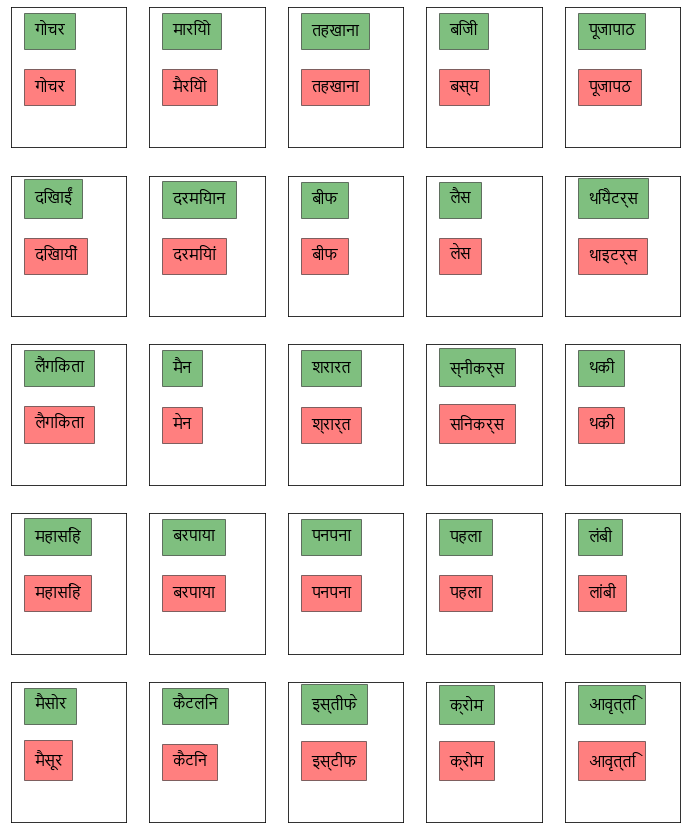

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname = 'Nirmala.ttf',size=15)

#
# Creating 2 subplots
fig, axs = plt.subplots(5, 5,figsize=(12,15))
 
# Accessing each axes object to plot the data through returned array
for i in range(5):
  for j in range(5):
    axs[i][j].get_xaxis().set_visible(False)
    axs[i][j].get_yaxis().set_visible(False)
    axs[i][j].text(0.2,0.4,random_index_predictions[i*5+j],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
    axs[i][j].text(0.2,0.8,test_target[random_index_nos[i*5+j]][1:-1],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})
wandb.init(project="A3-q4")
wandb.run.name="Random prediction"
wandb.log({'Random': [wandb.Image(fig)]})
#plt.grid(True, which='both')

plt.show()

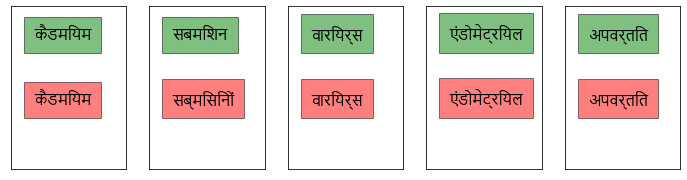

In [52]:

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname = 'Nirmala.ttf',size=15)

#
# Creating 2 subplots
fig, axs = plt.subplots(1, len(long_index_nos),figsize=(12,3))
 
# Accessing each axes object to plot the data through returned array
for i in range(len(long_index_nos)):
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
  axs[i].text(0.2,0.4,long_index_predictions[i],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
  axs[i].text(0.2,0.8,test_target[long_index_nos[i]][1:-1],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})

#plt.grid(True, which='both')
wandb.init(project="A3-q4")
wandb.run.name="long_Word_predictions"
wandb.log({'Long_Words': [wandb.Image(fig)]})
plt.show()

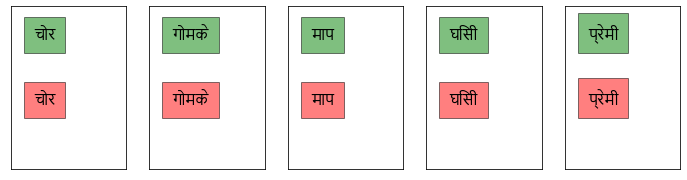

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname = 'Nirmala.ttf',size=15)

#
# Creating 2 subplots
fig, axs = plt.subplots(1, len(short_index_nos),figsize=(12,3))
 
# Accessing each axes object to plot the data through returned array
for i in range(len(short_index_nos)):
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
  axs[i].text(0.2,0.4,short_index_predictions[i],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
  axs[i].text(0.2,0.8,test_target[short_index_nos[i]][1:-1],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})

#plt.grid(True, which='both')
wandb.init(project="A3-q4")
wandb.run.name="Short_Word_predictions"
wandb.log({'Short_Words': [wandb.Image(fig)]})
plt.show()

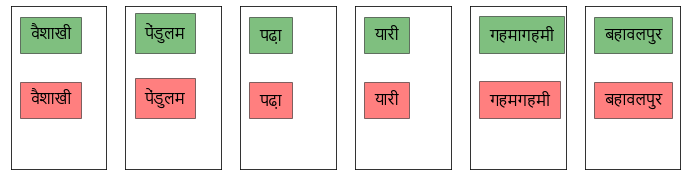

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname = 'Nirmala.ttf',size=15)

#
# Creating 2 subplots
fig, axs = plt.subplots(1, len(confusing_indexes),figsize=(12,3))
 
# Accessing each axes object to plot the data through returned array
for i in range(len(confusing_indexes)):
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
  axs[i].text(0.2,0.4,confusing_indexes_predictions[i],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
  axs[i].text(0.2,0.8,test_target[confusing_indexes[i]][1:-1],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})

#plt.grid(True, which='both')
wandb.init(project="A3-q4")
wandb.run.name="Confusing_Word_predictions"
wandb.log({'Confusing_Words': [wandb.Image(fig)]})
plt.show()

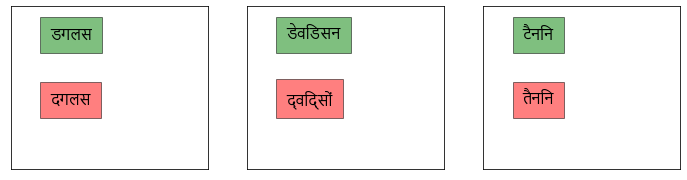

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname = 'Nirmala.ttf',size=15)

#
# Creating 2 subplots
fig, axs = plt.subplots(1, len(same_hindi_english),figsize=(12,3))
 
# Accessing each axes object to plot the data through returned array
for i in range(len(same_hindi_english)):
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
  axs[i].text(0.2,0.4,same_hindi_english_predictions[i],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
  axs[i].text(0.2,0.8,test_target[same_hindi_english[i]][1:-1],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})

#plt.grid(True, which='both')
wandb.init(project="A3-q4")
wandb.run.name="Same_English_hindi_Words_predictions"
wandb.log({'Same_English_Hindi_Words': [wandb.Image(fig)]})
plt.show()

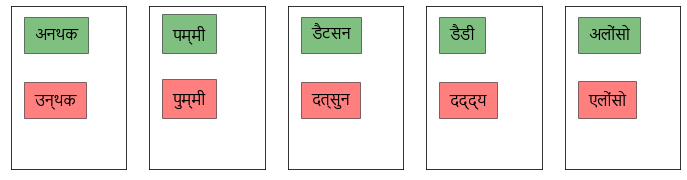

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname = 'Nirmala.ttf',size=15)

#
# Creating 2 subplots
fig, axs = plt.subplots(1, len(vowel_confusion_indxes),figsize=(12,3))
 
# Accessing each axes object to plot the data through returned array
for i in range(len(vowel_confusion_indxes)):
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
  axs[i].text(0.2,0.4,vowel_confusion_indxes_predictions[i],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
  axs[i].text(0.2,0.8,test_target[vowel_confusion_indxes[i]][1:-1],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})

#plt.grid(True, which='both')
wandb.init(project="A3-q4")
wandb.run.name="vowel_confusion_Words_predictions"
wandb.log({'vowel_confusion_Words': [wandb.Image(fig)]})
plt.show()

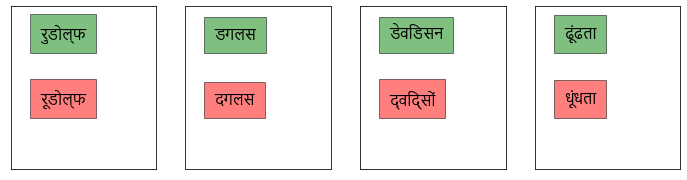

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
font_prop = FontProperties(fname = 'Nirmala.ttf',size=15)

#
# Creating 2 subplots
fig, axs = plt.subplots(1, len(two_face_chars_indxes),figsize=(12,3))
 
# Accessing each axes object to plot the data through returned array
for i in range(len(two_face_chars_indxes)):
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
  axs[i].text(0.2,0.4,two_face_chars_indxes_predictions[i],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
  axs[i].text(0.2,0.8,test_target[two_face_chars_indxes[i]][1:-1],fontsize = 20,fontproperties = font_prop,bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 10})
wandb.init(project="A3-q4")
wandb.run.name="two_face_chars_Words_predictions"
wandb.log({'two_face_chars_Words': [wandb.Image(fig)]})
plt.show()